In [1]:
#from google.colab import drive

In [2]:
#drive.mount('/content/drive')

In [3]:
#import os
#os.chdir("/content/drive")

In [4]:
#cd My Drive

In [5]:
#cd CS230-master

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import time
%matplotlib inline
# 
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

In [7]:
import os; 
#work-around to allow import from directory on same level
os.sys.path.append(os.path.dirname(os.path.abspath('.')))
from input.DataLoader import DataLoader
from input.GenerateBatch import GenerateBatch
from model.Model3 import train_generator

Using TensorFlow backend.


In [8]:
from sklearn.preprocessing import MinMaxScaler
from keras import regularizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense,Dropout,Activation, Lambda
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten
from keras.layers import  MaxPooling1D, MaxPooling2D,Reshape, BatchNormalization
from keras.utils import to_categorical
from keras.metrics import categorical_crossentropy
from scipy.stats import linregress
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
from keras.backend import transpose, permute_dimensions,squeeze
from keras.optimizers import Adam

#### Transfer Learning Experiment - TEST - Is it better to train on a set of stocks or just on the one you want to predict
#### Particularly important in cases like this where only limited data is available
#### For stock S Compare Two Models
#### First Model; Fit on five stocks (including S) and then predict S
#### Second Model: Fit and predict just on S

In [9]:
# PARAMETERS AND COMMENTs
#
# LSTM with 10bar target and 0-5.6-7 training/val 
# Train and predict for one stock vs training on all stocks and predicting on one
# standardize window = false
# Dropout back to 50;
# L2 Regularization on dense layer
configs={}
configs['batch_size']=500

configs['sequence_length']=20
configs['epochs']=100
configs['learning_rate']=.001
configs['learning_rate_decay']=0
configs['opt']=Adam(lr=configs['learning_rate'],
                   decay=configs['learning_rate_decay'])
configs['save_dir']='saved_models'
configs['nflag']=False #standardize each window
configs['stock']=0 # Predict first stock using the two approaches


traindays=[0,1,2,3,4,5,6,7] #training and val days to look at in dataset
valdays=[8,9]
colx=range(40)# columns to look at in dataset - 0-40 are LOB
#colx=np.concatenate([np.arange(20),86+np.arange(20)])
coly=148 # target 144-148 are 1,2,3,5,10
generate_files=True
print('trainday',traindays,'valdays',valdays,'colx',colx,'coly',coly)
print(configs)

trainday [0, 1, 2, 3, 4, 5, 6, 7] valdays [8, 9] colx range(0, 40) coly 148
{'batch_size': 500, 'sequence_length': 20, 'epochs': 100, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'opt': <keras.optimizers.Adam object at 0x7f9c0e73c198>, 'save_dir': 'saved_models', 'nflag': False, 'stock': 0}


### Generate data from zip files or retrieve from pkl files in directory

In [10]:
if generate_files==True:
  path='data/'
  d=DataLoader(path)
  traindf=d.get_days(traindays)
  trainoffset=d.get_stock_offset(traindays)
  valdf=d.get_days(valdays)
  valoffset=d.get_stock_offset(valdays)

  traindf.to_pickle("traindf.pkl")
  valdf.to_pickle("valdf.pkl")
  np.save("trainoffset",trainoffset)
  np.save("valoffset",valoffset)

else:
  traindf=pd.read_pickle('traindf.pkl')
  valdf=pd.read_pickle('valdf.pkl')
  trainoffset=np.load("trainoffset.npy")
  valoffset=np.load("valoffset.npy")

# Select X and Y training and dev data. Y is categorical
trainx=traindf.iloc[:,colx].values
trainy=to_categorical(traindf.iloc[:,coly].values-1)
valx=valdf.iloc[:,colx].values
valy=to_categorical(valdf.iloc[:,coly].values-1)



### Function to extract LOB data for a list of stocks from trainx and trainy

In [11]:
# select a subset of stocks
def select_stocks(s,dat,offset,ndays):
    ###############
    # Inputs:
    # s: list of stocks to select
    # dat: numpy array of data - shape rows are successive LOB snapshots; columns are data items (bid, ask...)
    # offset: offset to end of each stock in succession on each day 
    # ndays: number of days of data
    # Outputs:
    # newdat: numpy array for just stocks selected
    # newoffset: list of offsets to each stock on each day in newdat
    # 
    #################
    numstocks=5 # we have 5 stocks in total
    i=np.tile(np.arange(numstocks),ndays) #repeat our list of all 5 stocks over ndays
    b=np.zeros(i.shape) # boolean vector for stocks to retain
    for s1 in s: # for each stock we are keeping
        b=np.logical_or(b,s1==i)
    #begininning of each stock to include
    start=np.insert(offset,0,0)[:-1][b]
    #end of each stock to include
    end=offset[b]
    #
    # create index of lob snapshots to keep
    i=np.arange(dat.shape[0])
    cfbool=np.zeros(dat.shape[0]) #boolean vector for the rows we want
    for s,e in zip(start,end):
        cfbool=np.logical_or(cfbool,(s<=i)&(i<e))
    newcf=dat[cfbool] # data for only the stocks we are looking at
    newoffset=np.cumsum(end-start) #new offset to end of each stock for each day
    #
    return [newcf, newoffset]

### Build and compile model

In [12]:
class Model():
    """A class for an building and inferencing an lstm model"""

    def __init__(self):
        self.model = Sequential()
        self.tbCallback=callbacks.TensorBoard(log_dir='./Graph',histogram_freq=0,write_graph=True, write_images=True)

    def build_model(self,seq,cols):
        print("build_model2")
        self.model.add(LSTM(100,input_shape=(seq,cols),kernel_regularizer=regularizers.l2(0.01), return_sequences=False))
        self.model.add(Dropout(0.50))
        #self.model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation='relu'))
        #self.model.add(Dropout(0.20))
        self.model.add(Dense(3,activation="softmax"))
        opt=Adam(lr=configs['learning_rate'],decay=configs['learning_rate_decay'])
        self.model.compile(loss="categorical_crossentropy", optimizer=configs['opt'],metrics=['accuracy'])
        self.model.summary()

In [13]:
#Build a model for all 5 stocks and for each stock indivudually
m=Model()
m.build_model(configs['sequence_length'],len(colx))


build_model2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________


## 1. Model Fitting - First fit on all five stocks and then predict on one

In [14]:
training_generator=GenerateBatch(trainx,trainy,trainoffset)
val_generator=GenerateBatch(valx,valy,valoffset)

In [15]:
# out-of memory generative training
steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])

In [16]:
# GenerateBatch2 contains logic to avoid running over stock/day divides
history=train_generator(
    model=m.model,
    train_gen=training_generator.GenerateBatch2(configs['sequence_length'],
                                               configs['batch_size'],
                                               configs['nflag']),
    val_gen=val_generator.GenerateBatch2(configs['sequence_length'],
                                        configs['batch_size'],
                                        configs['nflag']),
    epochs=configs['epochs'],
    batch_size=configs['batch_size'],
    steps_per_epoch=steps_per_epoch,
    validation_steps=steps_per_epoch_val,
    save_dir=configs['save_dir']
    )

    

[Model] Training Started
[Model] 100 epochs, 500 batch size, 639.0 batches per epoch
Epoch 1/100
 - 34s - loss: 1.1869 - acc: 0.4370 - val_loss: 1.2109 - val_acc: 0.3740
Epoch 2/100
 - 32s - loss: 1.0564 - acc: 0.4603 - val_loss: 1.1343 - val_acc: 0.3931
Epoch 3/100
 - 32s - loss: 1.0433 - acc: 0.4665 - val_loss: 1.1747 - val_acc: 0.3840
Epoch 4/100
 - 32s - loss: 1.0424 - acc: 0.4682 - val_loss: 1.1345 - val_acc: 0.3949
Epoch 5/100
 - 32s - loss: 1.0397 - acc: 0.4712 - val_loss: 1.1441 - val_acc: 0.3987
Epoch 6/100
 - 32s - loss: 1.0360 - acc: 0.4766 - val_loss: 1.1334 - val_acc: 0.4071
Epoch 7/100
 - 32s - loss: 1.0285 - acc: 0.4783 - val_loss: 1.1502 - val_acc: 0.4013
Epoch 8/100
 - 32s - loss: 1.0242 - acc: 0.4833 - val_loss: 1.1285 - val_acc: 0.4050
Epoch 9/100
 - 32s - loss: 1.0224 - acc: 0.4856 - val_loss: 1.1276 - val_acc: 0.4099
Epoch 10/100
 - 32s - loss: 1.0122 - acc: 0.4917 - val_loss: 1.1466 - val_acc: 0.4082
Epoch 11/100
 - 32s - loss: 1.0072 - acc: 0.4956 - val_loss: 1.1

Epoch 96/100
 - 32s - loss: 0.7025 - acc: 0.7155 - val_loss: 0.9304 - val_acc: 0.6241
Epoch 97/100
 - 32s - loss: 0.7071 - acc: 0.7122 - val_loss: 0.9511 - val_acc: 0.6190
Epoch 98/100
 - 32s - loss: 0.7024 - acc: 0.7138 - val_loss: 0.9390 - val_acc: 0.6191
Epoch 99/100
 - 32s - loss: 0.7012 - acc: 0.7150 - val_loss: 0.9501 - val_acc: 0.6207
Epoch 100/100
 - 32s - loss: 0.6975 - acc: 0.7173 - val_loss: 0.9473 - val_acc: 0.6262
[Model] Training Completed. Model saved as saved_models/10122018-022435-e100.h5
Time taken: 0:52:58.802810


In [17]:
#from keras.models import load_model
#model = load_model('saved_models/04122018-125307-e20.h5')

Text(0,0.5,'Cost')

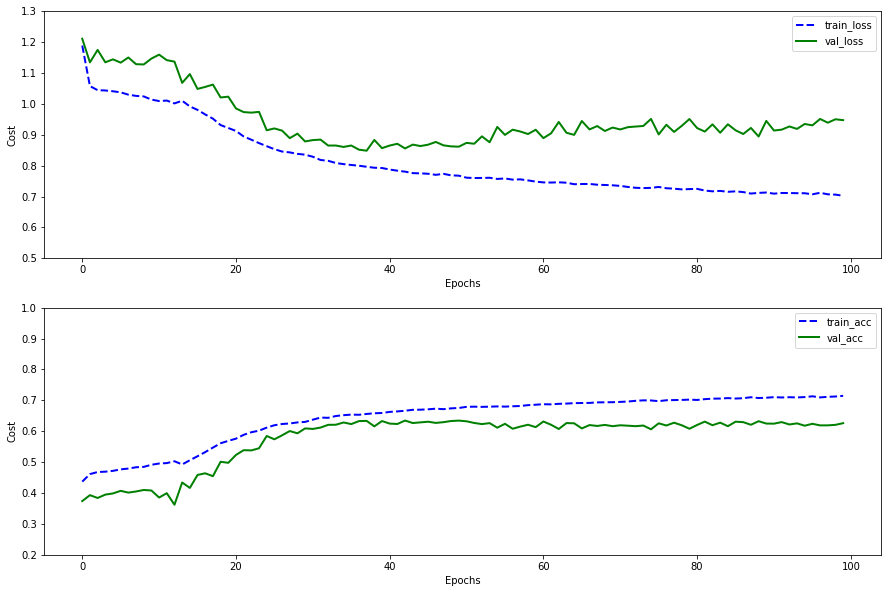

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
plt.legend()
plt.ylim([.5,1.3])
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.subplot(2,1,2)
plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
plt.legend()
plt.ylim([.2,1.])
plt.xlabel('Epochs')
plt.ylabel('Cost')

In [19]:
# predict for each stock
for s in range(5):
    trainx_one,trainoffset_one = select_stocks([s],trainx,trainoffset,len(traindays))
    trainy_one,_=select_stocks([s],trainy,trainoffset,len(traindays))

    valx_one,valoffset_one=select_stocks([s],valx,valoffset,len(valdays))
    valy_one,_=select_stocks([s],valy,valoffset,len(valdays))

    # make our predictions - start from beginning
    # but only predict on ONE Stock
    training_generator=GenerateBatch(trainx_one,trainy_one,trainoffset_one)
    val_generator=GenerateBatch(valx_one,valy_one,valoffset_one)
    train_gen=training_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])
    val_gen=val_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])

    # steps per epoch changes for each stock
    steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
    steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
    y_train=[]
    yhat_train=[]
    y_val=[]
    yhat_val=[]

    # predict using same sequence lengths and batches as in training - Predict just on one stock
    for i in range(int(steps_per_epoch)):
        dat=next(train_gen)
        y_train.append(dat[1])
        yhat_train.append(m.model.predict(dat[0]))
    for i in range(int(steps_per_epoch_val)):
        dat=next(val_gen)
        y_val.append(dat[1])
        yhat_val.append(m.model.predict(dat[0]))
                                            

    burn_in=0 # drop early predictions 
    y_train=np.concatenate(y_train).reshape(-1,3)[burn_in:]
    yhat_train=np.concatenate(yhat_train).reshape(-1,3)[burn_in:]
    y_val=np.concatenate(y_val).reshape(-1,3)[burn_in:]
    yhat_val=np.concatenate(yhat_val).reshape(-1,3)[burn_in:]


    # How well have we done on training data
    print ("Training for stock %d " % s)
    Y=np.argmax(y_train,axis=1)
    Yhat=np.argmax(yhat_train,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    print(classification_report(Yhat,Y))
    print("cohen kappa score: %.2f" %cohen_kappa_score(Yhat,Y))
    # How well have we done on test data
    print("Validation for stock %d" % s)
    Y=np.argmax(y_val,axis=1)
    Yhat=np.argmax(yhat_val,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    print(classification_report(Yhat,Y))
    print("cohen kappa score: %.2f" % cohen_kappa_score(Yhat,Y))

Training for stock 0 
             precision    recall  f1-score   support

          0       0.75      0.58      0.65     15161
          1       0.44      0.58      0.50      2053
          2       0.49      0.64      0.55      8617

avg / total       0.64      0.60      0.61     25831

cohen kappa score: 0.31
Validation for stock 0
             precision    recall  f1-score   support

          0       0.76      0.55      0.64     16086
          1       0.07      0.18      0.10       623
          2       0.48      0.65      0.55      9352

avg / total       0.64      0.58      0.59     26061

cohen kappa score: 0.23
Training for stock 1 
             precision    recall  f1-score   support

          0       0.80      0.74      0.77     25534
          1       0.48      0.62      0.54      4954
          2       0.76      0.77      0.76     22896

avg / total       0.75      0.74      0.75     53384

cohen kappa score: 0.56
Validation for stock 1
             precision    recall  

## 2.  Model Fitting - Second fit on one stock and then predict on that one 



build_model2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________
stock 0
trainx_one.shape (25983, 40)
trainy_one.shape (25983, 3)
[Model] Training Started
[Model] 100 epochs, 500 batch size, 56.0 batches per epoch
Epoch 1/100
 - 4s - loss: 1.1196 - acc: 0.4723 - val_loss: 0.9449 - val_acc: 0.4494
Epoch 2/100
 - 3s - loss: 0.9684 - acc: 0.4814 - val_loss: 0.9198 - val_acc: 0.4494
Epoch 3/100
 - 3s - loss: 0.9559 - acc: 0.4831 - val_loss: 0.9123 - val_

Epoch 87/100
 - 3s - loss: 0.8678 - acc: 0.6061 - val_loss: 0.8822 - val_acc: 0.5756
Epoch 88/100
 - 3s - loss: 0.8712 - acc: 0.6079 - val_loss: 0.8718 - val_acc: 0.5796
Epoch 89/100
 - 3s - loss: 0.8717 - acc: 0.6064 - val_loss: 0.8852 - val_acc: 0.5724
Epoch 90/100
 - 3s - loss: 0.8685 - acc: 0.6068 - val_loss: 0.8668 - val_acc: 0.5855
Epoch 91/100
 - 3s - loss: 0.8666 - acc: 0.6097 - val_loss: 0.8804 - val_acc: 0.5684
Epoch 92/100
 - 3s - loss: 0.8759 - acc: 0.6028 - val_loss: 0.8613 - val_acc: 0.5950
Epoch 93/100
 - 3s - loss: 0.8762 - acc: 0.6007 - val_loss: 0.8806 - val_acc: 0.5743
Epoch 94/100
 - 3s - loss: 0.8679 - acc: 0.6085 - val_loss: 0.8566 - val_acc: 0.5888
Epoch 95/100
 - 3s - loss: 0.8707 - acc: 0.6044 - val_loss: 0.8515 - val_acc: 0.5998
Epoch 96/100
 - 3s - loss: 0.8732 - acc: 0.6070 - val_loss: 0.9093 - val_acc: 0.5745
Epoch 97/100
 - 3s - loss: 0.8850 - acc: 0.5922 - val_loss: 0.8812 - val_acc: 0.5657
Epoch 98/100
 - 3s - loss: 0.8770 - acc: 0.5979 - val_loss: 0.966

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               56400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 303       
Total params: 56,703
Trainable params: 56,703
Non-trainable params: 0
_________________________________________________________________
stock 1
trainx_one.shape (53536, 40)
trainy_one.shape (53536, 3)
[Model] Training Started
[Model] 100 epochs, 500 batch size, 111.0 batches per epoch
Epoch 1/100
 - 7s - loss: 1.0738 - acc: 0.5252 - val_loss: 1.1218 - val_acc: 0.3961
Epoch 2/100
 - 5s - loss: 0.9462 - acc: 0.5585 - val_loss: 1.1259 - val_acc: 0.3974
Epoch 3/100
 - 5s - loss: 0.9389 - acc: 0.5642 - val_loss: 1.1727 - val_acc: 0.3425


 - 5s - loss: 0.6187 - acc: 0.7803 - val_loss: 1.0536 - val_acc: 0.5764
Epoch 88/100
 - 5s - loss: 0.5896 - acc: 0.7947 - val_loss: 1.0513 - val_acc: 0.5866
Epoch 89/100
 - 5s - loss: 0.5795 - acc: 0.7986 - val_loss: 1.0877 - val_acc: 0.5752
Epoch 90/100
 - 5s - loss: 0.5711 - acc: 0.8010 - val_loss: 1.1025 - val_acc: 0.5806
Epoch 91/100
 - 5s - loss: 0.5616 - acc: 0.8051 - val_loss: 1.0784 - val_acc: 0.5732
Epoch 92/100
 - 5s - loss: 0.5675 - acc: 0.8027 - val_loss: 1.0896 - val_acc: 0.5756
Epoch 93/100
 - 5s - loss: 0.5570 - acc: 0.8085 - val_loss: 1.1012 - val_acc: 0.5740
Epoch 94/100
 - 5s - loss: 0.5562 - acc: 0.8099 - val_loss: 1.0915 - val_acc: 0.5856
Epoch 95/100
 - 5s - loss: 0.5496 - acc: 0.8104 - val_loss: 1.0940 - val_acc: 0.5831
Epoch 96/100
 - 5s - loss: 0.5576 - acc: 0.8080 - val_loss: 1.0773 - val_acc: 0.5917
Epoch 97/100
 - 5s - loss: 0.5622 - acc: 0.8081 - val_loss: 1.1043 - val_acc: 0.5762
Epoch 98/100
 - 5s - loss: 0.5622 - acc: 0.8061 - val_loss: 1.0945 - val_acc: 

Epoch 65/100
 - 5s - loss: 0.6370 - acc: 0.7675 - val_loss: 1.1332 - val_acc: 0.5439
Epoch 66/100
 - 5s - loss: 0.6394 - acc: 0.7655 - val_loss: 1.0927 - val_acc: 0.5560
Epoch 67/100
 - 5s - loss: 0.6271 - acc: 0.7720 - val_loss: 1.1159 - val_acc: 0.5614
Epoch 68/100
 - 5s - loss: 0.6163 - acc: 0.7760 - val_loss: 1.1403 - val_acc: 0.5631
Epoch 69/100
 - 5s - loss: 0.6131 - acc: 0.7805 - val_loss: 1.1561 - val_acc: 0.5613
Epoch 70/100
 - 5s - loss: 0.6094 - acc: 0.7834 - val_loss: 1.1627 - val_acc: 0.5551
Epoch 71/100
 - 5s - loss: 0.6094 - acc: 0.7827 - val_loss: 1.1712 - val_acc: 0.5640
Epoch 72/100
 - 5s - loss: 0.6178 - acc: 0.7774 - val_loss: 1.1388 - val_acc: 0.5675
Epoch 73/100
 - 5s - loss: 0.6104 - acc: 0.7836 - val_loss: 1.1636 - val_acc: 0.5659
Epoch 74/100
 - 5s - loss: 0.5947 - acc: 0.7883 - val_loss: 1.1894 - val_acc: 0.5586
Epoch 75/100
 - 5s - loss: 0.5900 - acc: 0.7912 - val_loss: 1.2329 - val_acc: 0.5569
Epoch 76/100
 - 5s - loss: 0.5885 - acc: 0.7941 - val_loss: 1.269

Epoch 43/100
 - 7s - loss: 0.7517 - acc: 0.7055 - val_loss: 0.9001 - val_acc: 0.6524
Epoch 44/100
 - 7s - loss: 0.7455 - acc: 0.7101 - val_loss: 0.9016 - val_acc: 0.6450
Epoch 45/100
 - 7s - loss: 0.7430 - acc: 0.7105 - val_loss: 0.8918 - val_acc: 0.6551
Epoch 46/100
 - 7s - loss: 0.7377 - acc: 0.7139 - val_loss: 0.9115 - val_acc: 0.6433
Epoch 47/100
 - 7s - loss: 0.7324 - acc: 0.7147 - val_loss: 0.9170 - val_acc: 0.6413
Epoch 48/100
 - 7s - loss: 0.7323 - acc: 0.7160 - val_loss: 0.8920 - val_acc: 0.6460
Epoch 49/100
 - 7s - loss: 0.7301 - acc: 0.7161 - val_loss: 0.9213 - val_acc: 0.6421
Epoch 50/100
 - 7s - loss: 0.7306 - acc: 0.7166 - val_loss: 0.9036 - val_acc: 0.6415
Epoch 51/100
 - 7s - loss: 0.7273 - acc: 0.7210 - val_loss: 0.9492 - val_acc: 0.6242
Epoch 52/100
 - 7s - loss: 0.7224 - acc: 0.7229 - val_loss: 0.9594 - val_acc: 0.6332
Epoch 53/100
 - 7s - loss: 0.7270 - acc: 0.7202 - val_loss: 0.9619 - val_acc: 0.6319
Epoch 54/100
 - 7s - loss: 0.7142 - acc: 0.7277 - val_loss: 0.982

Epoch 21/100
 - 12s - loss: 1.0990 - acc: 0.3612 - val_loss: 1.1103 - val_acc: 0.3641
Epoch 22/100
 - 12s - loss: 1.1002 - acc: 0.3587 - val_loss: 1.1044 - val_acc: 0.3698
Epoch 23/100
 - 12s - loss: 1.0995 - acc: 0.3632 - val_loss: 1.1223 - val_acc: 0.3664
Epoch 24/100
 - 12s - loss: 1.0989 - acc: 0.3673 - val_loss: 1.1157 - val_acc: 0.3629
Epoch 25/100
 - 12s - loss: 1.1022 - acc: 0.3720 - val_loss: 1.1320 - val_acc: 0.3703
Epoch 26/100
 - 12s - loss: 1.1025 - acc: 0.3599 - val_loss: 1.1162 - val_acc: 0.3661
Epoch 27/100
 - 12s - loss: 1.0993 - acc: 0.3616 - val_loss: 1.1150 - val_acc: 0.3626
Epoch 28/100
 - 12s - loss: 1.0982 - acc: 0.3779 - val_loss: 1.1488 - val_acc: 0.3708
Epoch 29/100
 - 12s - loss: 1.0990 - acc: 0.3714 - val_loss: 1.1281 - val_acc: 0.3680
Epoch 30/100
 - 12s - loss: 1.0982 - acc: 0.3697 - val_loss: 1.1141 - val_acc: 0.3618
Epoch 31/100
 - 12s - loss: 1.1013 - acc: 0.3584 - val_loss: 1.1078 - val_acc: 0.3707
Epoch 32/100
 - 12s - loss: 1.0969 - acc: 0.3703 - val

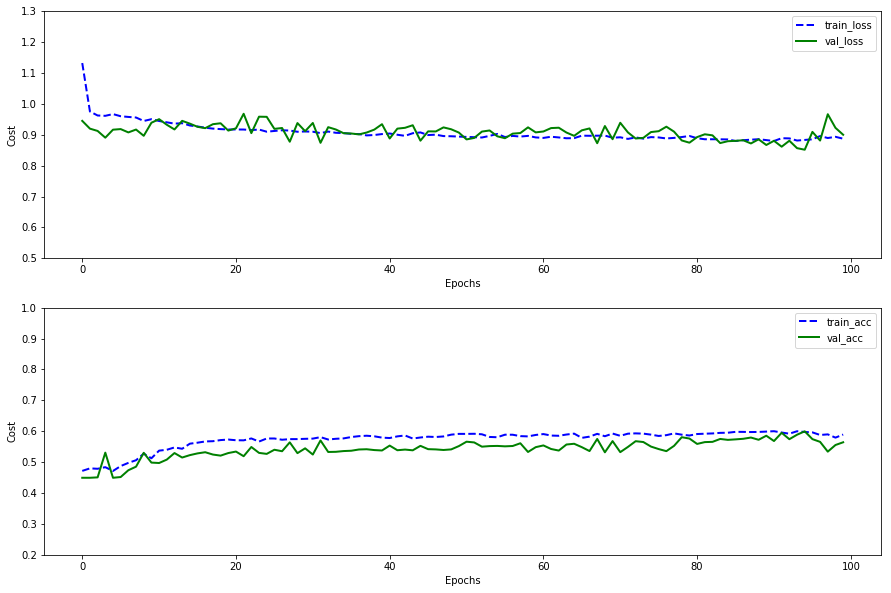

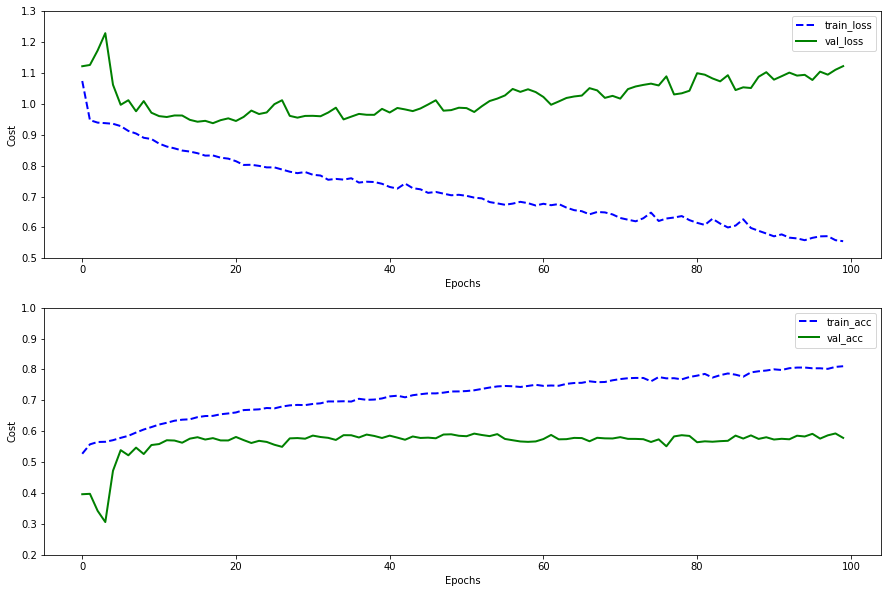

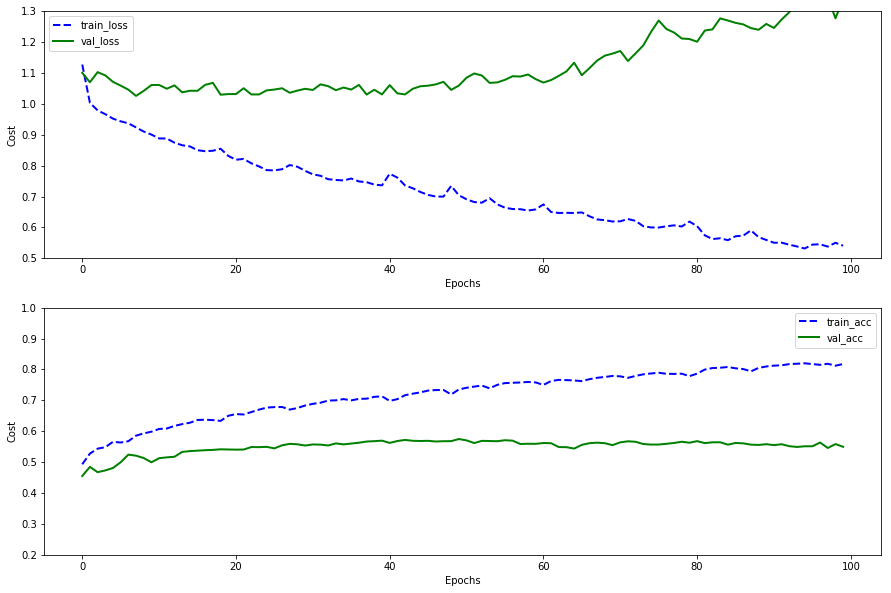

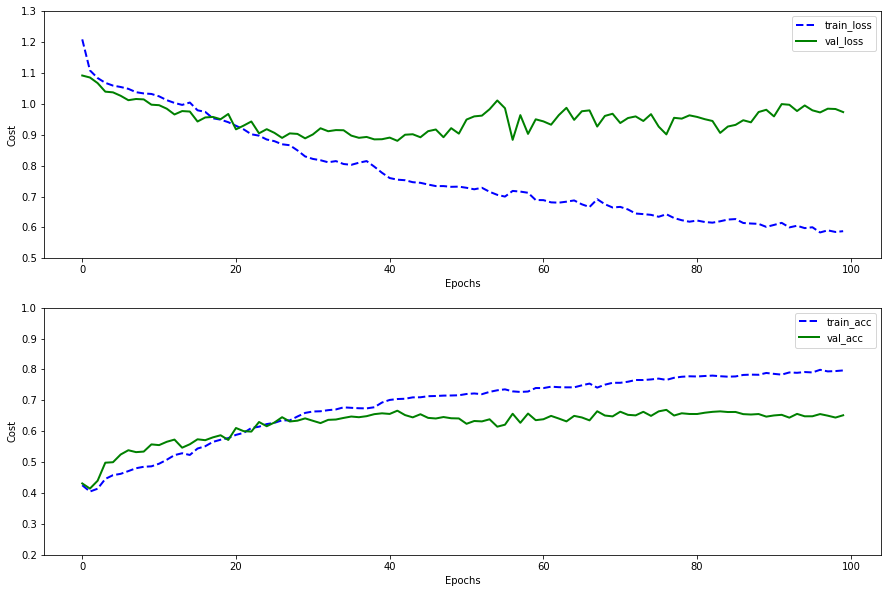

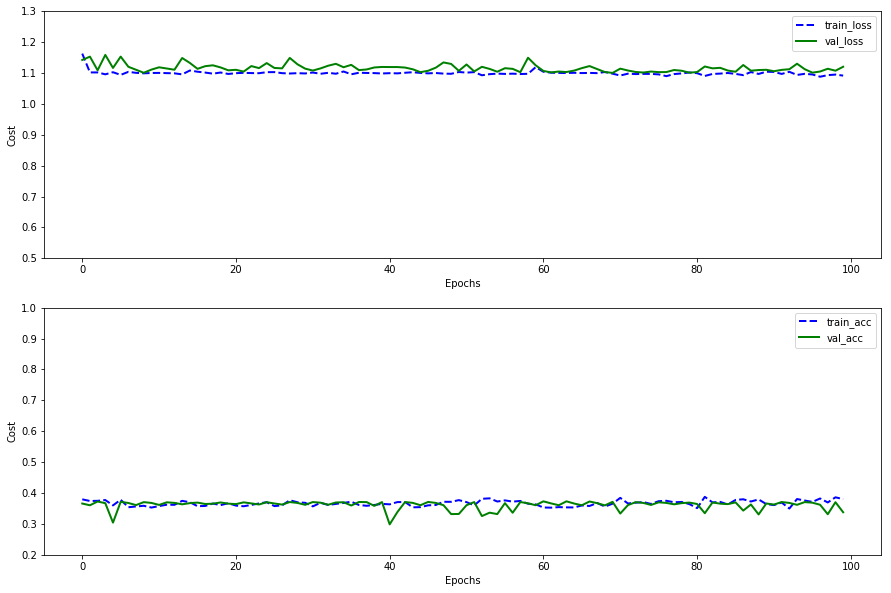

In [20]:
# Do the whole thing for each stock -- later should break this up into separate functions
# rather than repeating from above
dat_train=[] # save data for each stock for later display
dat_val=[]
kappa_train=[]
kappa_val=[]

for s in range(5):
    #build a new model for each stock s
    m_one=Model()
    m_one.build_model(configs['sequence_length'],len(colx))
    #select data for stock s
    trainx_one,trainoffset_one = select_stocks([s],trainx,trainoffset,len(traindays))
    trainy_one,_=select_stocks([s],trainy,trainoffset,len(traindays))
    print("stock %d" % s)
    print("trainx_one.shape",trainx_one.shape)
    print("trainy_one.shape",trainy_one.shape)

    valx_one,valoffset_one=select_stocks([s],valx,valoffset,len(valdays))
    valy_one,_=select_stocks([s],valy,valoffset,len(valdays))
    
    # create generator for stock s
    training_generator=GenerateBatch(trainx_one,trainy_one,trainoffset_one)
    val_generator=GenerateBatch(valx_one,valy_one,valoffset_one)

    # steps per epoch
    steps_per_epoch=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])
    steps_per_epoch_val=training_generator.epoch_size(configs['sequence_length'],
                                              configs['batch_size'])

    # GenerateBatch2 contains logic to avoid running over stock/day divides
    history=train_generator(
        model=m_one.model,
        train_gen=training_generator.GenerateBatch2(configs['sequence_length'],
                                               configs['batch_size'],
                                               configs['nflag']),
        val_gen=val_generator.GenerateBatch2(configs['sequence_length'],
                                        configs['batch_size'],
                                        configs['nflag']),
        epochs=configs['epochs'],
        batch_size=configs['batch_size'],
        steps_per_epoch=steps_per_epoch,
        validation_steps=steps_per_epoch_val,
        save_dir=configs['save_dir']
        )

    

    plt.figure(figsize=(15,10))
    plt.subplot(2,1,1)
    plt.plot(history.history['loss'],'b--',lw=2,label='train_loss')
    plt.plot(history.history['val_loss'],'g-',lw=2,label='val_loss')
    plt.legend()
    plt.ylim([.5,1.3])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.subplot(2,1,2)
    plt.plot(history.history['acc'],'b--',lw=2,label='train_acc')
    plt.plot(history.history['val_acc'],'g-',lw=2,label='val_acc')
    plt.legend()
    plt.ylim([.2,1.])
    plt.xlabel('Epochs')
    plt.ylabel('Cost')
    plt.savefig('loss_one %d' % s)
    
    

    # make our predictions - start from beginning
    # but only predict on ONE Stock
    train_gen=training_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])
    val_gen=val_generator.GenerateBatch2(configs['sequence_length'],configs['batch_size'],configs['nflag'])

    y_train=[]
    yhat_train=[]
    y_val=[]
    yhat_val=[]

    # predict using same sequence lengths and batches as training -- Predict just on one stock
    for i in range(int(steps_per_epoch)):
        dat=next(train_gen)
        y_train.append(dat[1])
        yhat_train.append(m_one.model.predict(dat[0]))
    for i in range(int(steps_per_epoch_val)):
        dat=next(val_gen)
        y_val.append(dat[1])
        yhat_val.append(m_one.model.predict(dat[0]))
                                            

    burn_in=0 # drop early predictions 
    y_train=np.concatenate(y_train).reshape(-1,3)[burn_in:]
    yhat_train=np.concatenate(yhat_train).reshape(-1,3)[burn_in:]
    y_val=np.concatenate(y_val).reshape(-1,3)[burn_in:]
    yhat_val=np.concatenate(yhat_val).reshape(-1,3)[burn_in:]


    # How well have we done on training data
    print ("Training %d " %s)
    Y=np.argmax(y_train,axis=1)
    Yhat=np.argmax(yhat_train,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    cr=classification_report(Yhat,Y)
    print(cr)
    dat_train.append(cr)
    ck=cohen_kappa_score(Yhat,Y)
    print("cohen kappa score: %.2f" % ck)
    kappa_train.append(ck)
    # How well have we done on test data
    print("Validation %d " %s)
    Y=np.argmax(y_val,axis=1)
    Yhat=np.argmax(yhat_val,axis=1)
    c=confusion_matrix(Y,Yhat)
    c=np.concatenate((c,np.sum(c,axis=1).reshape(-1,1)),axis=1)
    c=np.concatenate((c,np.sum(c,axis=0).reshape(1,-1)),axis=0)
    #print(c)
    cr=classification_report(Yhat,Y)
    print(cr)
    dat_val.append(cr)
    ck=cohen_kappa_score(Yhat,Y)
    print("cohen kappa score: %.2f" % ck)
    kappa_val.append(ck)

In [21]:
#classification reports for training data (one stock case)
for i,j in enumerate(dat_train):
    print(i)
    print(j)

0
             precision    recall  f1-score   support

          0       0.72      0.59      0.65     14224
          1       0.00      0.00      0.00         0
          2       0.62      0.60      0.61     11607

avg / total       0.67      0.60      0.63     25831

1
             precision    recall  f1-score   support

          0       0.83      0.77      0.80     25781
          1       0.51      0.57      0.54      5825
          2       0.77      0.81      0.79     21778

avg / total       0.77      0.76      0.77     53384

2
             precision    recall  f1-score   support

          0       0.82      0.78      0.80     20861
          1       0.67      0.67      0.67      7664
          2       0.76      0.80      0.78     18463

avg / total       0.77      0.77      0.77     46988

3
             precision    recall  f1-score   support

          0       0.80      0.76      0.78     25806
          1       0.84      0.70      0.76     22490
          2       0.68      

In [22]:
#classification reports for validation data
for i,j in enumerate(dat_val):
    print(i)
    print(j)

0
             precision    recall  f1-score   support

          0       0.84      0.52      0.64     19019
          1       0.00      0.00      0.00         0
          2       0.38      0.69      0.49      7042

avg / total       0.72      0.56      0.60     26061

1
             precision    recall  f1-score   support

          0       0.69      0.61      0.65     25760
          1       0.20      0.29      0.24      6324
          2       0.61      0.63      0.62     21251

avg / total       0.60      0.58      0.59     53335

2
             precision    recall  f1-score   support

          0       0.61      0.54      0.57     19014
          1       0.42      0.55      0.48     10432
          2       0.59      0.56      0.57     17511

avg / total       0.56      0.55      0.55     46957

3
             precision    recall  f1-score   support

          0       0.64      0.59      0.62     21630
          1       0.73      0.72      0.73     30120
          2       0.53      

In [23]:
print(kappa_train)

[0.27105241357838494, 0.6045200007346255, 0.6360881808569182, 0.645850166131653, 0.0]


In [24]:
print(kappa_val)

[0.19368864745400705, 0.3123959717578517, 0.31631862633296826, 0.46224406958948416, 0.0]
